# Retake Exam 2022 - Hedging a liability cash flow and portfolio optimization

# Guided Solution


Below, I will examplify how to solve the problems. I will not, necessarily, provide the full solution. 

Results may depend on modelling choices. 

# Packages

Imported functions and modules are used for solving both problems. 

In [132]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Python packages
"""

import numpy as np
import seaborn as sns
from scipy import stats, optimize
from scipy.linalg import sqrtm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime

# remember to install pandas-datareader  if not installed
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

"""
Own packages
"""

import codelib.portfolio_optimization.diversification as dm
import codelib.portfolio_optimization.risk_budget as rb
import codelib.portfolio_optimization.risk_metrics as rm

# covariance estimator 
from codelib.statistics.moments import calculate_cov_mat, cov_to_corr_matrix, corr_to_cov_matrix
from codelib.statistics.moments import calculate_log_norm_cov_mat, calculate_log_norm_mean

from codelib.fixed_income.cash_flows import CashFlow
from codelib.fixed_income.curves.nelson_siegel_svensson_curve import NelsonSiegelSvenssonCurve

from codelib.dal.fred_yield_data import get_nominal_yield_data

# plotting
from codelib.visualization.layout import DefaultStyle, default_colors
from codelib.visualization.base import fan_chart, risk_waterfall_chart, waterfall_chart
DefaultStyle();

"""
Hedging
"""

from hedging import solve_hedging_problem
import cvxpy as cp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem 1: Hedging a cash flow

## Retirement cash flow

In [2]:
cf_time_points = np.arange(11.0, 31.0, 1.0)
cash_flows = 100_000 * (1 + 0.02)**np.arange(20)

retirement_cf = CashFlow(time_points=cf_time_points, flows=cash_flows)

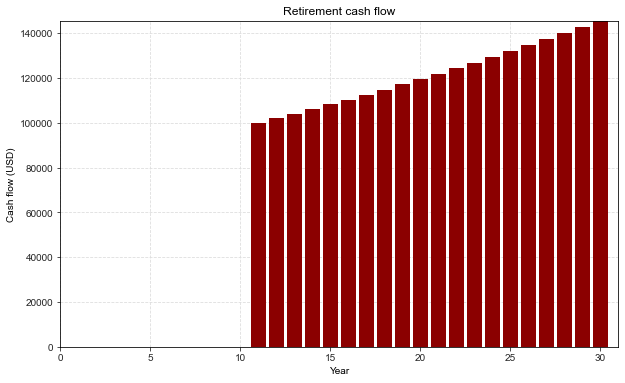

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(cf_time_points, cash_flows, color="darkred"); 
ax.set_xlim([0, 31])
ax.set_xlabel('Year')
ax.set_ylabel('Cash flow (USD)')
ax.set_title('Retirement cash flow');

## Available bonds

We start by defining the relevant bond universe. 

In [4]:
"""
Define a function creating a bullet cash flow
"""

def create_bullet_cash_flow(maturity: float, coupon_rate: float, freq: int = 1, face_value: float = 1.0):
    
    delta = 1.0 / freq
    
    terms = np.arange(delta, maturity + delta, delta)
    flows = np.ones_like(terms) * coupon_rate * face_value / freq
    flows[-1] += face_value
    
    return (terms, flows)

In [5]:
"""
Create a dictionary with relevant bond information
"""

bond_info_dict = dict()
bond_info_dict['1Y'] = (np.ones(1), np.ones(1))
bond_info_dict['5Y'] = create_bullet_cash_flow(5.0, 0.02)
bond_info_dict['7Y'] = create_bullet_cash_flow(7.0, 0.02)
bond_info_dict['10Y'] = create_bullet_cash_flow(10.0, 0.03)
bond_info_dict['15Y'] = create_bullet_cash_flow(15.0, 0.03)
bond_info_dict['20Y'] = create_bullet_cash_flow(20.0, 0.03)
bond_info_dict['25Y'] = create_bullet_cash_flow(25.0, 0.04)
bond_info_dict['30Y'] = create_bullet_cash_flow(30.0, 0.04)

In [6]:
"""
Create cash flow dictionaries
"""

bond_cf_dict = dict()
for k, v in bond_info_dict.items():
    bond_cf_dict[k] = CashFlow(time_points=v[0], flows=v[1])

In [7]:
bond_cf_dict['30Y'].time_points

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30.])

In [8]:
bond_cf_dict['30Y'].flows

array([0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 1.04])

## Yield data

To be able to price the bonds, we need a yield curve. We obtain the nomial yield curve from FRED using the function `get_nominal_yield_data`. 

In [9]:
"""
Parameters for yield curve
"""

all_parameters = get_nominal_yield_data(output_type='parameters').loc['2000-01-03':, ]
all_parameters.head(1)

,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
Date,,,,,,
2000-01-03,3.685087,1.579927,3.637107,9.814584,0.989721,9.955324


In [10]:
"""
Yield data
"""

yield_tenors =  np.arange(1.0, 31.0, 1.0)
all_zero_yields = get_nominal_yield_data(output_type='zero_yields')
all_zero_yields = all_zero_yields.dropna() /  100.0 
all_zero_yields = all_zero_yields.loc['2000-01-01':, :]

In [11]:
all_zero_yields.head(3)

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.061055,0.063057,0.063604,0.064046,0.064639,0.065347,0.066090,0.066803,0.067444,0.067992,...,0.068287,0.067970,0.067623,0.067252,0.066860,0.066453,0.066032,0.065601,0.065163,0.064720
2000-01-04,0.060481,0.062220,0.062590,0.063042,0.063705,0.064475,0.065250,0.065968,0.066598,0.067124,...,0.067411,0.067128,0.066820,0.066492,0.066147,0.065789,0.065420,0.065044,0.064663,0.064278
2000-01-05,0.061096,0.063101,0.063598,0.064120,0.064821,0.065609,0.066388,0.067102,0.067721,0.068233,...,0.068366,0.068075,0.067761,0.067428,0.067079,0.066718,0.066348,0.065971,0.065590,0.065206


## Initial yield curve

To plot the initial yield curve, we can either use the zero coupon yields directly or extract the parameters for the Nelson Siegel Svensson curve. 

In [12]:
"""
Select parameters defining initial yield curve
"""

initial_date = '2000-01-03'

theta1 = all_parameters.loc[initial_date, "TAU1"]
theta2 = all_parameters.loc[initial_date, "TAU2"]
beta0 = all_parameters.loc[initial_date, "BETA0"] / 100.0
beta1 = all_parameters.loc[initial_date, "BETA1"] / 100.0
beta2 = all_parameters.loc[initial_date, "BETA2"] / 100.0
beta3 = all_parameters.loc[initial_date, "BETA3"] / 100.0

In [13]:
"""
Initial yield curve
"""

init_nss_curve = NelsonSiegelSvenssonCurve(theta1, theta2, beta0, beta1, beta2, beta3)

In [14]:
yields = all_zero_yields.loc['2000-01-03',:]

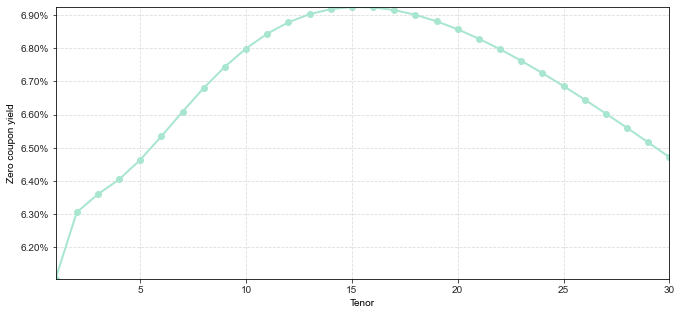

In [15]:
"""
Plot initial yield curve
"""

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(yield_tenors, yields)
ax.scatter(yield_tenors, init_nss_curve.zero_rate_vector(yield_tenors))

yticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(yticks)

ax.set_ylabel("Zero coupon yield")
ax.set_xlabel("Tenor"); 

## Initial Price, duration and convexity

The easiest way to calculate initial price, duration and convexity is to use the methods `present_value`, `fisher_weil_duration` or `fisher_weil_convexity`. It would of course also be possible to code functions performing these calculations. 

In [16]:
"""
Define dataframe for storing results
"""

df_res = pd.DataFrame(columns=['PV', 'D', 'C'])

In [17]:
"""
Calculate PV, Duration, and Convextiy
"""

df_res.loc['Retirement CF', :] = [retirement_cf.present_value(init_nss_curve),
                                  retirement_cf.fisher_weil_duration(init_nss_curve),
                                  retirement_cf.fisher_weil_convexity(init_nss_curve)]

for k, v in bond_cf_dict.items():
    df_res.loc[k, :] = [v.present_value(init_nss_curve),
                        v.fisher_weil_duration(init_nss_curve),
                        v.fisher_weil_convexity(init_nss_curve)]

In [18]:
"""
Show resuls
"""

df_res

,PV,D,C
Retirement CF,625268.083957,19.071071,396.258851
1Y,0.940771,1.0,1.0
5Y,0.80676,4.780996,23.480913
7Y,0.738658,6.517973,44.408595
10Y,0.719336,8.503843,80.020732
15Y,0.628129,11.3838,154.144957
20Y,0.571503,13.464165,232.163454
25Y,0.654058,14.00929,277.268034
30Y,0.641558,15.05757,339.72157


We have a long dated retirement cash flow why the duration is large - in fact larger than for any of the available bonds. This implies that we need to leverage the portfolio by selling e.g. the one year zero coupon bond to match the duration of the retirement cash flow. 

The present value of the bonds is not increasing / decreasing monotonically with time to maturity. The present value dependens on the coupon rate. 

## Resample monthly data

In [19]:
"""
Resample parameters monthly
"""
all_parameters_monthly = all_parameters.resample('BMS').first()
all_parameters_monthly.head(5)

,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
Date,,,,,,
2000-01-03,3.685087,1.579927,3.637107,9.814584,0.989721,9.955324
2000-02-01,5.305664,-0.067768,2.821844,3.837114,0.833734,7.226516
2000-03-01,5.146122,0.388427,2.220056,3.862581,0.892297,6.432310
2000-04-03,4.206061,1.583977,3.129517,5.248417,1.123447,9.382575
2000-05-01,5.532059,0.168454,2.526735,2.021463,0.783143,5.182586


In [20]:
"""
Resample yields monthly
"""
all_zero_yields_monthly = all_zero_yields.resample('BMS').first()
all_zero_yields_monthly.head(3)

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.061055,0.063057,0.063604,0.064046,0.064639,0.065347,0.066090,0.066803,0.067444,0.067992,...,0.068287,0.067970,0.067623,0.067252,0.066860,0.066453,0.066032,0.065601,0.065163,0.064720
2000-02-01,0.063016,0.065357,0.065797,0.065924,0.066052,0.066201,0.066340,0.066446,0.066505,0.066515,...,0.064533,0.064277,0.064020,0.063764,0.063511,0.063262,0.063017,0.062778,0.062544,0.062315
2000-03-01,0.062618,0.064396,0.064822,0.064985,0.065115,0.065228,0.065306,0.065334,0.065306,0.065225,...,0.062473,0.062180,0.061892,0.061609,0.061334,0.061066,0.060806,0.060555,0.060311,0.060077


In [21]:
"""
Define dataframes to store results
"""
df_dur = pd.DataFrame(index=all_zero_yields_monthly.index, columns=df_res.index)
df_con = pd.DataFrame(index=all_zero_yields_monthly.index, columns=df_res.index)
df_price = pd.DataFrame(index=all_zero_yields_monthly.index, columns=df_res.index)

In [22]:
"""
Perform calculations for each date in the future
"""
for idx, date in enumerate(df_dur.index): 
    
    """
    Define yield curve for specific point in time
    """
    # obtain yield curve parameters
    theta1 = all_parameters_monthly.loc[date, "TAU1"]
    theta2 = all_parameters_monthly.loc[date, "TAU2"]
    beta0 = all_parameters_monthly.loc[date, "BETA0"] / 100.0
    beta1 = all_parameters_monthly.loc[date, "BETA1"] / 100.0
    beta2 = all_parameters_monthly.loc[date, "BETA2"] / 100.0
    beta3 = all_parameters_monthly.loc[date, "BETA3"] / 100.0
    
    # create yield curve
    temp_nss_curve = NelsonSiegelSvenssonCurve(theta1, theta2, beta0, beta1, beta2, beta3)
    
    """
    Duration
    """
    
    temp_dur = [retirement_cf.fisher_weil_duration(curve=temp_nss_curve, time_shift=idx * 1.0 / 12.0)]
    # no time shift since we assume a new every period
    temp_dur.append(bond_cf_dict['1Y'].fisher_weil_duration(curve=temp_nss_curve)) 
    # time shift since the remaining time to expiry of the bonds decreases
    temp_dur = (temp_dur +  [v.fisher_weil_duration(curve=temp_nss_curve, time_shift=idx * 1.0 / 12.0) 
                            for v in list(bond_cf_dict.values())[1:]])
    
    """
    Convexity
    """
    
    temp_con = [retirement_cf.fisher_weil_convexity(curve=temp_nss_curve, time_shift=idx * 1.0 / 12.0)]
    # no time shift since we assume a new every period
    temp_con.append(bond_cf_dict['1Y'].fisher_weil_convexity(curve=temp_nss_curve)) 
    # time shift since the remaining time to expiry of the bonds decreases
    temp_con = (temp_con +  [v.fisher_weil_convexity(curve=temp_nss_curve, time_shift=idx * 1.0 / 12.0) 
                            for v in list(bond_cf_dict.values())[1:]])
    
    """
    Price
    """
    
    temp_price = [retirement_cf.present_value(curve=temp_nss_curve, time_shift=idx * 1.0 / 12.0)]
    # no time shift since we assume a new every period
    temp_price.append(bond_cf_dict['1Y'].present_value(curve=temp_nss_curve)) 
    # time shift since the remaining time to expiry of the bonds decreases    
    temp_price = (temp_price +  [v.present_value(curve=temp_nss_curve, time_shift=idx * 1.0 / 12.0) 
                            for v in list(bond_cf_dict.values())[1:]])

    df_dur.loc[date, :] = temp_dur
    df_con.loc[date, :] = temp_con
    df_price.loc[date, :] = temp_price

## Plotting duration and convexity

Clearly, the duration and convexity of the retirement cash flow and the bullet bonds are generally decreasing with time. However, due to fluctuations of the yield curve the metrics may increase over shorter time intervals.  

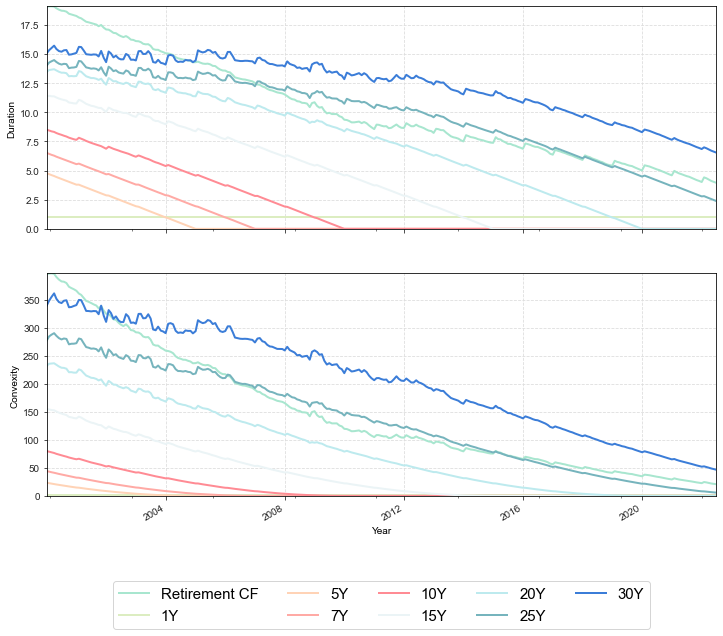

In [23]:
"""
Plot duration and convexity
"""

fig, ax = plt.subplots(2, figsize=(12, 10), sharex=True)

df_dur.plot(ax=ax[0], legend=False)
ax[0].set_ylabel("Duration")


df_con.plot(ax=ax[1], legend=False)
ax[1].set_ylabel("Convexity")
ax[1].set_xlabel("Year")

ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, fontsize=15);

## Initial hedging portfolio

We define a function able to calculate the optimal hedging portfolio.

It can be imported into the notebook using. 

```python 
from hedging import solve_hedging_problem
```



In [24]:
"""
Define function to solve hedging problem 

It can also be imported from the module hedging. 

"""

if False: 
    import numpy as np
    from cvxopt import matrix
    from cvxopt.solvers import qp

    def solve_hedging_problem(h_matrix: np.ndarray, d_vector: np.array, delta: float = 3.0): 

        """
        Solves hedging problem with leverage constraint. Leverage is only allowed in first asset. 
        """

        lambda_mat = h_matrix @ h_matrix.T
        theta_vec = - h_matrix @ d_vector 
        n = h_matrix.shape[0]

        """
        Define vectors and matrice
        """

        P = matrix(np.block([[lambda_mat, np.zeros((n,n)), np.zeros((n,n))],
                         [np.zeros((n,n)), np.zeros((n,n)), np.zeros((n,n))],
                         [np.zeros((n,n)), np.zeros((n,n)), np.zeros((n,n))]]) + np.eye(3*n) * 0.0000001)

        q = matrix(np.r_[theta_vec, np.zeros(n), np.zeros(n)])

        """
        Define inequality constraints
        """

        G = matrix(np.r_[np.block([[np.zeros((1,n)), np.ones((1,n)), np.ones((1,n))]]),
                         -np.eye(3*n)])

        h = matrix(np.r_[delta, 999999, np.zeros(3*n - 1)])


        """
        Define equality constraints
        """

        A = matrix(np.r_[np.block([[np.ones((1,n)), np.zeros((1,n)), np.zeros((1,n))]]),
                         np.block([[np.eye(n), np.eye(n), -np.eye(n)]])])

        b = matrix(np.r_[np.ones((1,1)), np.zeros((n, 1))])

        """
        Solve problem
        """
        sol = np.array(qp(P, q , G, h, A, b)['x']).flatten()

        return sol[:n]

### Duration matched portfolio

The only thing we need is to define $\mathbf{H}$ and $\mathbf{d}$ correctly in order to solve the hedging problem. 

In [25]:
"""
Duration matched portfolio
"""

h_matrix = np.ones((8, 1))
h_matrix[:, 0] = df_res.D.values[1:] 
d_vector = np.ones(1)
d_vector[0] = df_res.D.values[0]

dur_matched_port = solve_hedging_problem(h_matrix, d_vector, delta=3.0)
dur_matched_port

     pcost       dcost       gap    pres   dres
 0:  1.1203e+09 -1.1244e+09  3e+12  8e-01  3e+03
 1:  1.0211e+09 -1.4972e+09  4e+10  1e-02  5e+01
 2:  7.9964e+07 -1.2742e+08  3e+09  9e-04  4e+00
 3:  7.3909e+03 -3.7632e+06  4e+07  1e-05  5e-02
 4: -1.8144e+02 -2.4177e+06  3e+06  1e-07  5e-04
 5: -1.7957e+02 -5.5661e+04  6e+04  6e-10  3e-06
 6: -1.7958e+02 -7.6584e+02  6e+02  6e-12  3e-08
 7: -1.8074e+02 -2.0709e+02  3e+01  3e-13  1e-09
 8: -1.8185e+02 -1.8317e+02  1e+00  9e-14  2e-11
 9: -1.8185e+02 -1.8187e+02  1e-02  7e-13  2e-13
10: -1.8185e+02 -1.8185e+02  1e-04  8e-13  2e-15
Optimal solution found.


array([-0.63101985,  0.10473943,  0.12557168,  0.15869393,  0.23124985,
        0.30114666,  0.32336568,  0.38625261])

In [26]:
# target duration
df_dur['Retirement CF'].iloc[0]

19.07107121410225

In [27]:
# hedge port
df_res.D.values[1:] @ dur_matched_port

19.071059873944385

In [28]:
# target duration
df_con['Retirement CF'].iloc[0]

396.25885091310363

In [29]:
# hedge port
df_res.C.values[1:] @ dur_matched_port # <- large deviation because we are not trying to match

346.5421824340526

### Duration and convexity matched portfolio

In [30]:
"""
Duration and convexity matched portfolio
"""

h_matrix = np.ones((8, 2))
h_matrix[:, 0] = df_res.D.values[1:] 
h_matrix[:, 1] = df_res.C.values[1:] 

d_vector = np.ones(2)
d_vector[0] = df_res.D.values[0]
d_vector[1] = df_res.C.values[0]

dur_con_matched_port = solve_hedging_problem(h_matrix, d_vector, delta=3.0)
dur_con_matched_port

     pcost       dcost       gap    pres   dres
 0:  1.1610e+10 -1.1615e+10  2e+12  5e-01  1e+01
 1:  2.6217e+09 -2.7579e+09  1e+11  3e-02  7e-01
 2:  4.1196e+06 -2.7691e+07  3e+09  7e-04  2e-02
 3:  1.0157e+06 -5.4882e+06  8e+07  2e-05  4e-04
 4: -7.7177e+04 -3.2769e+06  4e+06  3e-07  6e-06
 5: -7.2954e+04 -3.0018e+05  2e+05  4e-11  1e-13
 6: -7.6780e+04 -1.0565e+05  3e+04  7e-12  2e-14
 7: -7.8681e+04 -8.0940e+04  2e+03  2e-12  8e-16
 8: -7.8691e+04 -7.8722e+04  3e+01  6e-13  9e-17
 9: -7.8692e+04 -7.8697e+04  6e+00  9e-14  1e-16
10: -7.8692e+04 -7.8694e+04  2e+00  2e-14  1e-16
11: -7.8692e+04 -7.8692e+04  7e-02  2e-15  5e-17
Optimal solution found.


array([-0.48802655,  0.08595703,  0.10187468,  0.09348608,  0.03653061,
        0.09134297,  0.17002243,  0.90881275])

In [31]:
# target duration
df_dur['Retirement CF'].iloc[0]

19.07107121410225

In [32]:
# hedge port
df_res.D.values[1:] @ dur_con_matched_port

19.094060256038773

In [33]:
# target duration
df_con['Retirement CF'].iloc[0]

396.25885091310363

In [34]:
# hedge port
df_res.C.values[1:] @ dur_con_matched_port

396.2578486330241

## Optimal hedging portfolios over time 

We repeat the above calcuations for each point in time. It is important to drop bonds from the optimization when expiring. 

In [35]:
"""
Define dataframe to store results
"""

df_opt_hedge_port = pd.DataFrame(data=np.zeros((len(df_dur.index), 8)),
                                 index=df_dur.index,
                                 columns=df_dur.columns[1:])

In [36]:
"""
Perform hedging for each point in time
"""

for i, date in enumerate(df_opt_hedge_port.index): 
    
    # select relevant bonds
    temp_dur = df_dur.iloc[i,  1:]
    temp_con = df_con.iloc[i,  1:]
    
    active_indicator = (temp_dur > 0.0).values
    num_active_bonds = np.sum(active_indicator)
    
    temp_dur = temp_dur[active_indicator]
    temp_con = temp_con[active_indicator]
    
    # Define input parameters for optimizer 
    h_matrix = np.ones((num_active_bonds, 2))
    h_matrix[:, 0] = (df_dur.iloc[i, :].values[1:])[active_indicator]
    h_matrix[:, 1] = (df_con.iloc[i, :].values[1:])[active_indicator]

    d_vector = np.ones(2)
    d_vector[0] = df_dur.iloc[i, :].values[0] 
    d_vector[1] = df_con.iloc[i, :].values[0]
    
    # find hedge portfolio
    dur_con_matched_port = solve_hedging_problem(h_matrix, d_vector, delta=3.0)
    
    # store results 
    df_opt_hedge_port.iloc[i, active_indicator] = dur_con_matched_port

     pcost       dcost       gap    pres   dres
 0:  1.1610e+10 -1.1615e+10  2e+12  5e-01  1e+01
 1:  2.6217e+09 -2.7579e+09  1e+11  3e-02  7e-01
 2:  4.1196e+06 -2.7691e+07  3e+09  7e-04  2e-02
 3:  1.0157e+06 -5.4882e+06  8e+07  2e-05  4e-04
 4: -7.7177e+04 -3.2769e+06  4e+06  3e-07  6e-06
 5: -7.2954e+04 -3.0018e+05  2e+05  4e-11  1e-13
 6: -7.6780e+04 -1.0565e+05  3e+04  7e-12  2e-14
 7: -7.8681e+04 -8.0940e+04  2e+03  2e-12  8e-16
 8: -7.8691e+04 -7.8722e+04  3e+01  6e-13  9e-17
 9: -7.8692e+04 -7.8697e+04  6e+00  9e-14  1e-16
10: -7.8692e+04 -7.8694e+04  2e+00  2e-14  1e-16
11: -7.8692e+04 -7.8692e+04  7e-02  2e-15  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1410e+10 -1.1415e+10  2e+12  5e-01  1e+01
 1:  2.6349e+09 -2.7665e+09  1e+11  3e-02  7e-01
 2:  4.1946e+06 -2.8328e+07  3e+09  7e-04  1e-02
 3:  9.4928e+05 -5.3745e+06  8e+07  2e-05  4e-04
 4: -7.6779e+04 -3.2328e+06  4e+06  2e-07  3e-06
 5: -7.4468e+04 -1.8276e+05  1e+05  9e-10  2e-0

 2:  5.1834e+06 -2.9578e+07  3e+09  8e-04  2e-02
 3:  1.0032e+06 -5.0332e+06  7e+07  2e-05  3e-04
 4: -6.4531e+04 -3.0056e+06  3e+06  1e-07  3e-06
 5: -6.3784e+04 -1.4470e+05  8e+04  3e-10  6e-09
 6: -6.4487e+04 -6.9766e+04  5e+03  2e-11  4e-10
 7: -6.4544e+04 -6.4608e+04  6e+01  5e-13  4e-12
 8: -6.4544e+04 -6.4552e+04  8e+00  7e-14  4e-13
 9: -6.4545e+04 -6.4548e+04  3e+00  4e-15  1e-16
10: -6.4545e+04 -6.4545e+04  3e-02  1e-15  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0148e+10 -1.0152e+10  2e+12  6e-01  1e+01
 1:  2.6281e+09 -2.7104e+09  1e+11  3e-02  6e-01
 2:  5.0604e+06 -2.9004e+07  3e+09  8e-04  2e-02
 3:  1.0532e+06 -5.0682e+06  7e+07  2e-05  4e-04
 4: -6.2521e+04 -2.9946e+06  3e+06  9e-08  2e-06
 5: -6.2025e+04 -1.1928e+05  6e+04  7e-10  2e-08
 6: -6.2569e+04 -6.5902e+04  3e+03  4e-11  8e-10
 7: -6.2595e+04 -6.2639e+04  4e+01  4e-13  9e-12
 8: -6.2596e+04 -6.2603e+04  7e+00  7e-14  1e-12
 9: -6.2597e+04 -6.2599e+04  2e+00  5e-15  1e-

 4: -4.9245e+04 -2.7892e+06  4e+06  4e-07  8e-06
 5: -4.8344e+04 -4.1576e+05  4e+05  5e-11  9e-14
 6: -4.8996e+04 -7.0371e+04  2e+04  1e-11  8e-15
 7: -4.9799e+04 -5.0832e+04  1e+03  2e-12  2e-15
 8: -4.9800e+04 -4.9821e+04  2e+01  9e-14  2e-16
 9: -4.9801e+04 -4.9804e+04  3e+00  1e-14  1e-16
10: -4.9801e+04 -4.9802e+04  4e-01  2e-15  7e-17
11: -4.9801e+04 -4.9801e+04  4e-03  2e-15  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.2139e+09 -8.2180e+09  2e+12  7e-01  1e+01
 1:  2.8947e+09 -3.1574e+09  1e+11  3e-02  6e-01
 2:  5.0291e+06 -3.2264e+07  3e+09  8e-04  1e-02
 3:  1.1525e+06 -4.9560e+06  7e+07  2e-05  3e-04
 4: -4.8621e+04 -2.7663e+06  4e+06  5e-07  9e-06
 5: -4.8070e+04 -4.6916e+05  4e+05  5e-11  1e-13
 6: -4.8683e+04 -7.1921e+04  2e+04  6e-12  2e-14
 7: -4.9557e+04 -5.0739e+04  1e+03  5e-13  1e-15
 8: -4.9558e+04 -4.9581e+04  2e+01  3e-13  2e-16
 9: -4.9559e+04 -4.9563e+04  4e+00  3e-14  8e-17
10: -4.9560e+04 -4.9560e+04  5e-01  2e-15  7e-

 2:  4.9690e+06 -4.8885e+07  3e+09  9e-04  1e-02
 3:  1.0784e+06 -4.8356e+06  6e+07  2e-05  3e-04
 4: -3.6200e+04 -2.5015e+06  4e+06  6e-07  9e-06
 5: -3.9656e+04 -5.3306e+05  5e+05  4e-11  1e-13
 6: -3.9849e+04 -5.7129e+04  2e+04  9e-12  7e-15
 7: -4.0212e+04 -4.0661e+04  4e+02  1e-13  1e-15
 8: -4.0213e+04 -4.0228e+04  2e+01  6e-14  1e-16
 9: -4.0214e+04 -4.0217e+04  3e+00  5e-15  7e-17
10: -4.0214e+04 -4.0214e+04  1e-01  2e-15  2e-16
11: -4.0214e+04 -4.0214e+04  1e-03  4e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.0652e+09 -5.0689e+09  3e+12  9e-01  1e+01
 1:  2.4724e+09 -3.1939e+09  1e+11  3e-02  5e-01
 2:  5.0492e+06 -5.1148e+07  3e+09  9e-04  1e-02
 3:  1.0262e+06 -4.7713e+06  6e+07  2e-05  3e-04
 4: -3.5585e+04 -2.4745e+06  4e+06  7e-07  1e-05
 5: -3.9745e+04 -5.6508e+05  5e+05  1e-11  1e-13
 6: -3.9942e+04 -5.8347e+04  2e+04  3e-11  2e-14
 7: -4.0326e+04 -4.0808e+04  5e+02  2e-12  5e-16
 8: -4.0326e+04 -4.0343e+04  2e+01  6e-14  3e-

 4: -2.7146e+04 -2.1490e+06  4e+06  6e-07  9e-06
 5: -2.9750e+04 -4.4296e+05  4e+05  2e-09  3e-08
 6: -2.9860e+04 -4.3699e+04  1e+04  7e-11  1e-09
 7: -3.0115e+04 -3.0456e+04  3e+02  7e-13  2e-12
 8: -3.0116e+04 -3.0130e+04  1e+01  5e-14  7e-14
 9: -3.0117e+04 -3.0121e+04  3e+00  4e-15  1e-16
10: -3.0117e+04 -3.0117e+04  6e-02  2e-15  7e-17
11: -3.0117e+04 -3.0117e+04  6e-04  1e-15  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3915e+09 -2.3949e+09  3e+12  1e+00  2e+01
 1:  1.4299e+09 -2.9310e+09  8e+10  3e-02  4e-01
 2:  3.2658e+06 -5.1979e+07  2e+09  7e-04  1e-02
 3:  7.8654e+05 -4.3079e+06  5e+07  2e-05  2e-04
 4: -2.7087e+04 -2.1198e+06  4e+06  6e-07  8e-06
 5: -2.9327e+04 -4.2690e+05  4e+05  6e-09  8e-08
 6: -2.9418e+04 -4.2871e+04  1e+04  2e-10  3e-09
 7: -2.9662e+04 -2.9988e+04  3e+02  1e-12  5e-12
 8: -2.9662e+04 -2.9676e+04  1e+01  9e-14  2e-13
 9: -2.9664e+04 -2.9667e+04  3e+00  1e-15  5e-17
10: -2.9664e+04 -2.9664e+04  6e-02  2e-15  8e-

 1:  1.3078e+09 -2.6217e+09  7e+10  3e-02  6e-01
 2:  2.6760e+06 -4.3682e+07  2e+09  6e-04  1e-02
 3:  9.7292e+05 -4.4057e+06  5e+07  2e-05  3e-04
 4: -1.7077e+04 -2.1276e+06  3e+06  2e-07  4e-06
 5: -1.8646e+04 -1.4645e+05  1e+05  5e-09  1e-07
 6: -1.9011e+04 -2.7129e+04  8e+03  3e-10  6e-09
 7: -1.9198e+04 -2.0265e+04  1e+03  2e-11  4e-10
 8: -1.9198e+04 -1.9219e+04  2e+01  4e-13  8e-12
 9: -1.9198e+04 -1.9201e+04  3e+00  3e-14  6e-13
10: -1.9198e+04 -1.9199e+04  1e-01  3e-15  1e-16
11: -1.9198e+04 -1.9198e+04  1e-03  1e-15  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1958e+09 -2.1992e+09  2e+12  1e+00  2e+01
 1:  1.2334e+09 -2.6026e+09  7e+10  3e-02  6e-01
 2:  2.6000e+06 -4.2738e+07  2e+09  6e-04  1e-02
 3:  9.3057e+05 -4.3341e+06  5e+07  2e-05  3e-04
 4: -1.6592e+04 -2.1048e+06  3e+06  2e-07  5e-06
 5: -1.8495e+04 -1.8586e+05  2e+05  7e-09  1e-07
 6: -1.8747e+04 -2.6789e+04  8e+03  3e-10  7e-09
 7: -1.8920e+04 -1.9547e+04  6e+02  1e-11  2e-

 8: -1.4327e+04 -1.4332e+04  5e+00  5e-15  9e-17
 9: -1.4327e+04 -1.4327e+04  3e-01  6e-16  1e-16
10: -1.4327e+04 -1.4327e+04  3e-03  1e-16  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.6367e+09 -8.6407e+09  2e+12  7e-01  3e+01
 1:  2.0607e+09 -2.2906e+09  1e+11  3e-02  1e+00
 2:  4.2079e+06 -2.3639e+07  2e+09  6e-04  3e-02
 3:  1.8386e+06 -5.3602e+06  7e+07  2e-05  9e-04
 4: -1.1496e+04 -2.7368e+06  3e+06  7e-12  7e-14
 5: -1.1674e+04 -6.8285e+04  6e+04  4e-11  1e-13
 6: -1.3944e+04 -2.0985e+04  7e+03  3e-12  9e-15
 7: -1.4158e+04 -1.4342e+04  2e+02  3e-13  2e-16
 8: -1.4158e+04 -1.4163e+04  5e+00  8e-15  5e-17
 9: -1.4158e+04 -1.4159e+04  3e-01  1e-15  5e-17
10: -1.4158e+04 -1.4158e+04  3e-03  5e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.4066e+09 -8.4105e+09  2e+12  7e-01  3e+01
 1:  2.0260e+09 -2.2860e+09  9e+10  3e-02  1e+00
 2:  4.2078e+06 -2.4511e+07  2e+09  6e-04  3e-02
 3:  1.8417e+06 -5.3745

 1:  1.1000e+09 -1.3578e+09  7e+10  2e-02  3e+00
 2:  5.6830e+06 -1.5587e+07  8e+08  2e-04  4e-02
 3:  1.1909e+06 -5.1853e+06  6e+07  2e-05  3e-03
 4: -4.4856e+03 -3.1539e+06  3e+06  3e-13  2e-13
 5: -4.5952e+03 -6.1487e+04  6e+04  3e-11  2e-13
 6: -6.4966e+03 -1.6016e+04  1e+04  4e-12  3e-14
 7: -6.9704e+03 -8.5336e+03  2e+03  2e-13  1e-15
 8: -6.9721e+03 -6.9983e+03  3e+01  2e-14  5e-17
 9: -6.9725e+03 -6.9775e+03  5e+00  3e-15  6e-17
10: -6.9728e+03 -6.9735e+03  7e-01  4e-15  8e-17
11: -6.9728e+03 -6.9728e+03  9e-03  2e-16  6e-17
12: -6.9728e+03 -6.9728e+03  9e-05  3e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.8781e+10 -1.8785e+10  1e+12  4e-01  6e+01
 1:  1.1027e+09 -1.3604e+09  7e+10  2e-02  3e+00
 2:  5.8336e+06 -1.5711e+07  8e+08  2e-04  4e-02
 3:  1.2162e+06 -5.1951e+06  6e+07  2e-05  3e-03
 4: -4.2190e+03 -3.1501e+06  3e+06  1e-13  1e-13
 5: -4.3254e+03 -6.0833e+04  6e+04  4e-11  1e-13
 6: -6.2134e+03 -1.5741e+04  1e+04  5e-12  2e-

Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.8356e+10 -1.8361e+10  1e+12  5e-01  7e+01
 1:  1.3206e+09 -1.5181e+09  8e+10  3e-02  4e+00
 2:  6.0481e+06 -1.6501e+07  1e+09  3e-04  4e-02
 3:  1.5173e+06 -5.2709e+06  7e+07  2e-05  3e-03
 4: -3.0221e+03 -3.0378e+06  3e+06  1e-12  2e-13
 5: -3.1298e+03 -5.7822e+04  5e+04  1e-10  2e-13
 6: -5.1515e+03 -1.4014e+04  9e+03  2e-11  3e-14
 7: -5.6733e+03 -6.6140e+03  9e+02  2e-13  3e-16
 8: -5.6753e+03 -5.6916e+03  2e+01  1e-14  2e-17
 9: -5.6756e+03 -5.6782e+03  3e+00  3e-15  6e-17
10: -5.6757e+03 -5.6759e+03  2e-01  2e-15  8e-17
11: -5.6757e+03 -5.6757e+03  2e-03  3e-16  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.8170e+10 -1.8174e+10  1e+12  5e-01  7e+01
 1:  1.3441e+09 -1.5331e+09  8e+10  3e-02  4e+00
 2:  5.9753e+06 -1.6501e+07  1e+09  3e-04  4e-02
 3:  1.5434e+06 -5.2719e+06  7e+07  2e-05  3e-03
 4: -3.0291e+03 -3.0246e+06  3e+06  6e-13  2e-13
 5: -3.1389e+03 -5.7754

     pcost       dcost       gap    pres   dres
 0:  1.4565e+10 -1.4569e+10  2e+12  6e-01  7e+01
 1:  1.4617e+09 -1.5434e+09  9e+10  3e-02  4e+00
 2:  5.7242e+06 -1.5402e+07  1e+09  4e-04  5e-02
 3:  1.7317e+06 -5.0612e+06  7e+07  2e-05  3e-03
 4: -3.0795e+03 -2.8102e+06  3e+06  3e-12  1e-13
 5: -3.1795e+03 -5.2577e+04  5e+04  2e-11  1e-13
 6: -5.0000e+03 -1.1971e+04  7e+03  3e-12  1e-14
 7: -5.4114e+03 -5.8405e+03  4e+02  3e-13  5e-16
 8: -5.4128e+03 -5.4217e+03  9e+00  8e-15  6e-17
 9: -5.4130e+03 -5.4139e+03  9e-01  2e-15  5e-17
10: -5.4130e+03 -5.4130e+03  2e-02  2e-15  7e-17
11: -5.4130e+03 -5.4130e+03  2e-04  8e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4241e+10 -1.4244e+10  2e+12  6e-01  7e+01
 1:  1.4511e+09 -1.5384e+09  9e+10  3e-02  4e+00
 2:  5.7676e+06 -1.5335e+07  1e+09  4e-04  5e-02
 3:  1.7355e+06 -5.0319e+06  7e+07  2e-05  3e-03
 4: -3.0145e+03 -2.7889e+06  3e+06  6e-12  3e-13
 5: -3.1114e+03 -5.1844e+04  5e+04  7e-11  2e-1

 9: -3.6451e+03 -3.6458e+03  7e-01  1e-15  8e-17
10: -3.6451e+03 -3.6451e+03  2e-02  8e-16  3e-17
11: -3.6451e+03 -3.6451e+03  2e-04  3e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.0399e+09 -8.0435e+09  2e+12  7e-01  9e+01
 1:  1.1926e+09 -1.6765e+09  8e+10  3e-02  4e+00
 2:  6.8855e+06 -2.1602e+07  1e+09  4e-04  6e-02
 3:  1.6218e+06 -4.8640e+06  6e+07  2e-05  3e-03
 4: -1.9629e+03 -2.4633e+06  2e+06  6e-12  3e-13
 5: -2.0165e+03 -4.1645e+04  4e+04  8e-11  4e-13
 6: -3.2029e+03 -8.9546e+03  6e+03  1e-11  4e-14
 7: -3.5801e+03 -4.0126e+03  4e+02  1e-13  3e-16
 8: -3.5820e+03 -3.5892e+03  7e+00  3e-15  6e-17
 9: -3.5822e+03 -3.5829e+03  7e-01  1e-15  6e-17
10: -3.5822e+03 -3.5822e+03  2e-02  2e-15  1e-16
11: -3.5822e+03 -3.5822e+03  2e-04  3e-16  3e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.5365e+09 -7.5401e+09  2e+12  7e-01  9e+01
 1:  1.1703e+09 -1.6955e+09  8e+10  3e-02  4e+00
 2:  6.9106e+06 -2.2313

10: -2.9507e+03 -2.9508e+03  5e-02  2e-15  1e-16
11: -2.9507e+03 -2.9507e+03  5e-04  6e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.0869e+09 -2.0901e+09  2e+12  8e-01  1e+02
 1:  6.2790e+08 -1.7559e+09  6e+10  3e-02  3e+00
 2:  5.5194e+06 -2.4121e+07  8e+08  3e-04  4e-02
 3:  9.0478e+05 -4.0617e+06  4e+07  2e-05  2e-03
 4: -1.5562e+03 -2.0666e+06  2e+06  2e-13  2e-13
 5: -1.5951e+03 -3.5824e+04  3e+04  1e-11  3e-13
 6: -2.5209e+03 -8.4309e+03  6e+03  1e-12  5e-14
 7: -2.8928e+03 -3.6946e+03  8e+02  3e-14  3e-16
 8: -2.8944e+03 -2.9082e+03  1e+01  9e-15  6e-17
 9: -2.8945e+03 -2.8962e+03  2e+00  1e-15  8e-17
10: -2.8946e+03 -2.8946e+03  5e-02  1e-15  2e-16
11: -2.8946e+03 -2.8946e+03  5e-04  6e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.6998e+10 -2.7002e+10  8e+11  3e-01  1e+02
 1:  2.8689e+08 -7.6128e+08  4e+10  1e-02  6e+00
 2:  1.1975e+07 -2.3986e+07  7e+08  2e-04  1e-01
 3:  4.9217e+05 -5.1095

     pcost       dcost       gap    pres   dres
 0:  2.8946e+10 -2.8950e+10  1e+12  3e-01  2e+02
 1:  3.3953e+08 -8.0875e+08  5e+10  2e-02  8e+00
 2:  1.3362e+07 -2.4586e+07  8e+08  3e-04  1e-01
 3:  7.2107e+05 -5.0736e+06  6e+07  2e-05  9e-03
 4: -4.3687e+02 -3.0660e+06  3e+06  1e-07  5e-05
 5: -8.3162e+02 -4.9391e+04  5e+04  8e-10  4e-07
 6: -1.5863e+03 -7.6032e+03  6e+03  9e-11  5e-08
 7: -2.1386e+03 -6.1920e+03  4e+03  4e-11  2e-08
 8: -2.1793e+03 -2.3504e+03  2e+02  1e-12  7e-10
 9: -2.1801e+03 -2.1862e+03  6e+00  5e-14  2e-11
10: -2.1802e+03 -2.1806e+03  5e-01  2e-15  1e-12
11: -2.1802e+03 -2.1802e+03  9e-03  1e-15  1e-14
12: -2.1802e+03 -2.1802e+03  9e-05  6e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.8002e+10 -2.8007e+10  1e+12  3e-01  2e+02
 1:  3.6546e+08 -8.2326e+08  5e+10  2e-02  7e+00
 2:  1.2456e+07 -2.3385e+07  8e+08  3e-04  1e-01
 3:  7.3460e+05 -5.0264e+06  6e+07  2e-05  8e-03
 4: -8.8132e+02 -3.0568e+06  3e+06  9e-08  4e-0

 4: -5.0052e+02 -2.8763e+06  3e+06  8e-09  4e-06
 5: -5.4595e+02 -4.0166e+04  4e+04  1e-10  5e-08
 6: -1.2415e+03 -8.3714e+03  7e+03  2e-11  8e-09
 7: -1.8080e+03 -6.8835e+03  5e+03  7e-12  3e-09
 8: -1.8178e+03 -1.9568e+03  1e+02  2e-13  8e-11
 9: -1.8182e+03 -1.8219e+03  4e+00  1e-14  2e-12
10: -1.8182e+03 -1.8185e+03  3e-01  9e-16  7e-14
11: -1.8182e+03 -1.8182e+03  4e-03  5e-16  7e-16
12: -1.8182e+03 -1.8182e+03  4e-05  6e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.6021e+10 -2.6025e+10  1e+12  4e-01  2e+02
 1:  3.6843e+08 -6.6049e+08  6e+10  2e-02  9e+00
 2:  1.4409e+07 -2.2162e+07  9e+08  3e-04  1e-01
 3:  9.6482e+05 -4.7033e+06  7e+07  2e-05  1e-02
 4: -4.6592e+02 -2.8538e+06  3e+06  3e-12  6e-13
 5: -4.8550e+02 -3.9865e+04  4e+04  1e-10  7e-13
 6: -1.1731e+03 -8.2962e+03  7e+03  2e-11  1e-13
 7: -1.7479e+03 -6.8144e+03  5e+03  7e-12  5e-14
 8: -1.7572e+03 -1.8955e+03  1e+02  2e-13  1e-15
 9: -1.7576e+03 -1.7612e+03  4e+00  8e-15  6e-

 3:  9.3986e+05 -4.2177e+06  7e+07  2e-05  1e-02
 4: -1.7488e+02 -2.5403e+06  3e+06  2e-12  7e-13
 5: -1.8847e+02 -3.4602e+04  3e+04  5e-11  8e-13
 6: -7.2043e+02 -7.0193e+03  6e+03  8e-12  1e-13
 7: -1.2890e+03 -5.8248e+03  5e+03  3e-12  5e-14
 8: -1.2932e+03 -1.4015e+03  1e+02  9e-14  1e-15
 9: -1.2935e+03 -1.2955e+03  2e+00  6e-15  6e-17
10: -1.2935e+03 -1.2936e+03  1e-01  2e-15  6e-17
11: -1.2935e+03 -1.2935e+03  1e-03  9e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6143e+10 -1.6147e+10  1e+12  5e-01  2e+02
 1:  2.7162e+08 -5.3379e+08  5e+10  2e-02  1e+01
 2:  1.6108e+07 -2.2880e+07  8e+08  3e-04  2e-01
 3:  9.1817e+05 -4.2091e+06  6e+07  2e-05  1e-02
 4: -1.3784e+02 -2.5097e+06  3e+06  4e-09  2e-06
 5: -1.6207e+02 -3.4085e+04  3e+04  9e-11  3e-08
 6: -6.8012e+02 -6.8998e+03  6e+03  2e-11  5e-09
 7: -1.2475e+03 -5.7702e+03  5e+03  6e-12  2e-09
 8: -1.2515e+03 -1.3595e+03  1e+02  1e-13  4e-11
 9: -1.2518e+03 -1.2537e+03  2e+00  6e-15  7e-

 6: -9.5337e+01 -5.8911e+03  6e+03  3e-10  1e-07
 7: -8.5317e+02 -4.1447e+03  3e+03  2e-11  8e-09
 8: -8.5543e+02 -9.4491e+02  9e+01  5e-13  2e-10
 9: -8.5550e+02 -8.5766e+02  2e+00  1e-14  5e-12
10: -8.5555e+02 -8.5564e+02  1e-01  2e-15  9e-14
11: -8.5555e+02 -8.5555e+02  1e-03  6e-15  8e-16
12: -8.5555e+02 -8.5555e+02  1e-05  8e-15  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.0263e+09 -2.0296e+09  1e+12  7e-01  3e+02
 1:  1.2594e+08 -1.0202e+09  3e+10  2e-02  8e+00
 2:  1.5050e+07 -3.3258e+07  6e+08  3e-04  1e-01
 3:  4.5817e+05 -4.0735e+06  4e+07  2e-05  9e-03
 4:  6.2054e+02 -2.0878e+06  2e+06  2e-07  8e-05
 5:  1.7990e+02 -9.0547e+04  9e+04  4e-09  2e-06
 6: -2.0510e+01 -5.9437e+03  6e+03  3e-10  1e-07
 7: -8.1551e+02 -4.3886e+03  4e+03  2e-11  9e-09
 8: -8.1936e+02 -9.3629e+02  1e+02  6e-13  3e-10
 9: -8.1950e+02 -8.2233e+02  3e+00  2e-14  7e-12
10: -8.1957e+02 -8.1974e+02  2e-01  3e-15  2e-13
11: -8.1958e+02 -8.1958e+02  2e-03  4e-15  1e-

 3:  7.4169e+04 -6.0536e+06  3e+07  9e-06  2e-02
 4:  6.8745e+02 -2.7765e+06  3e+06  8e-08  2e-04
 5:  5.3074e+02 -4.0146e+04  4e+04  9e-10  2e-06
 6:  1.0368e+02 -4.7259e+03  5e+03  1e-10  2e-07
 7: -5.9406e+02 -2.2739e+03  2e+03  5e-13  1e-15
 8: -5.9989e+02 -6.3396e+02  3e+01  3e-14  9e-16
 9: -5.9996e+02 -6.0184e+02  2e+00  1e-15  7e-17
10: -6.0004e+02 -6.0027e+02  2e-01  8e-16  6e-17
11: -6.0004e+02 -6.0005e+02  2e-03  6e-16  2e-16
12: -6.0004e+02 -6.0004e+02  2e-05  3e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.9526e+10 -2.9530e+10  7e+11  3e-01  6e+02
 1:  8.5935e+07 -6.0774e+08  2e+10  6e-03  1e+01
 2:  2.8194e+07 -6.2846e+07  1e+09  3e-04  7e-01
 3:  7.6648e+04 -6.0069e+06  3e+07  9e-06  2e-02
 4:  7.1802e+02 -2.7698e+06  3e+06  8e-08  2e-04
 5:  5.5811e+02 -4.0364e+04  4e+04  9e-10  2e-06
 6:  1.4107e+02 -4.6830e+03  5e+03  1e-10  2e-07
 7: -5.6981e+02 -2.3029e+03  2e+03  5e-13  9e-16
 8: -5.7543e+02 -6.1084e+02  4e+01  8e-14  1e-

 4:  8.6668e+02 -2.5805e+06  3e+06  9e-08  2e-04
 5:  7.0763e+02 -3.9073e+04  4e+04  9e-10  2e-06
 6:  4.2948e+02 -3.8292e+03  4e+03  1e-10  3e-07
 7: -3.3946e+02 -2.3835e+03  2e+03  9e-14  2e-15
 8: -3.4188e+02 -3.8040e+02  4e+01  2e-14  2e-15
 9: -3.4198e+02 -3.4374e+02  2e+00  7e-16  5e-17
10: -3.4205e+02 -3.4235e+02  3e-01  6e-16  1e-16
11: -3.4205e+02 -3.4206e+02  3e-03  4e-16  3e-16
12: -3.4205e+02 -3.4206e+02  3e-05  4e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.8770e+10 -2.8774e+10  9e+11  4e-01  1e+03
 1:  9.2172e+07 -4.7412e+08  1e+10  6e-03  2e+01
 2:  2.7121e+07 -5.5626e+07  1e+09  4e-04  1e+00
 3:  8.4651e+04 -4.8841e+06  3e+07  1e-05  3e-02
 4:  8.7760e+02 -2.5519e+06  3e+06  9e-08  2e-04
 5:  7.2265e+02 -3.8439e+04  4e+04  9e-10  3e-06
 6:  4.5351e+02 -3.7321e+03  4e+03  1e-10  3e-07
 7: -3.1805e+02 -2.3759e+03  2e+03  1e-13  1e-15
 8: -3.2026e+02 -3.5850e+02  4e+01  5e-14  1e-15
 9: -3.2036e+02 -3.2205e+02  2e+00  3e-15  2e-

We see that when a bond expires then it is dropped from the optimal hedging portfolio. In the beginning, we need much leverage to solve the problem since the duration of the retirement cash flow is large. With time, the need to leverage decreases. 

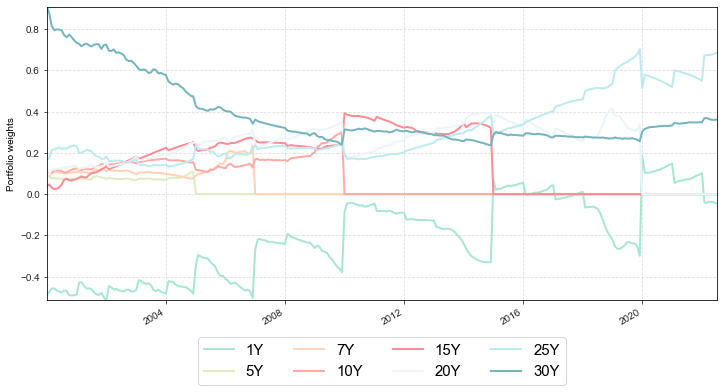

In [37]:
"""
Plot duration and convexity
"""

fig, ax = plt.subplots(figsize=(12, 6), sharex=True)

df_opt_hedge_port.plot(ax=ax, legend=False)
ax.set_ylabel("Portfolio weights")
ax.set_xlabel("")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=15);

In [38]:
df_opt_hedge_port

,1Y,5Y,7Y,10Y,15Y,20Y,25Y,30Y
Date,,,,,,,,
2000-01-03,-0.488027,0.085957,0.101875,0.093486,0.036531,0.091343,0.170022,0.908813
2000-02-01,-0.472882,0.087460,0.102210,0.093643,0.046764,0.095144,0.173004,0.874656
2000-03-01,-0.458261,0.074280,0.101010,0.103903,0.031107,0.118937,0.213642,0.815384
2000-04-03,-0.457592,0.078122,0.109124,0.117571,0.023604,0.118302,0.216193,0.794675
2000-05-01,-0.466819,0.076061,0.106876,0.116026,0.026020,0.121865,0.221295,0.798677
...,...,...,...,...,...,...,...,...
2022-03-01,-0.042817,0.000000,0.000000,0.000000,0.000000,0.000000,0.674137,0.368680
2022-04-01,-0.038636,0.000000,0.000000,0.000000,0.000000,0.000000,0.674336,0.364299
2022-05-02,-0.037160,0.000000,0.000000,0.000000,0.000000,0.000000,0.676941,0.360219


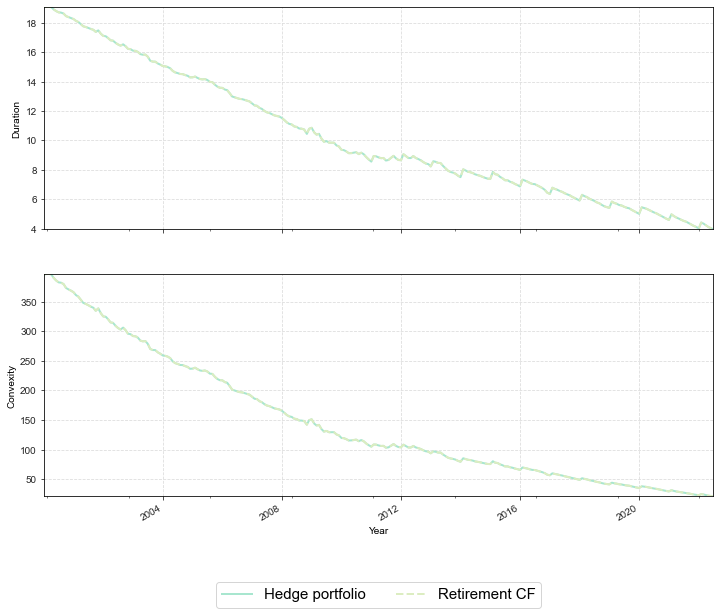

In [39]:
"""
Plot duration and convexity
"""

fig, ax = plt.subplots(2, figsize=(12, 10), sharex=True)

((df_dur.iloc[:, 1:] * df_opt_hedge_port).sum(axis=1)).plot(ax=ax[0], legend=False)
(df_dur.iloc[:, 0]).plot(ax=ax[0], legend=False, linestyle="--")
ax[0].set_ylabel("Duration")


((df_con.iloc[:, 1:] * df_opt_hedge_port).sum(axis=1)).plot(ax=ax[1], legend=False, label="Hedge portfolio")
ax[1].set_ylabel("Convexity")
(df_con.iloc[:, 0]).plot(ax=ax[1], legend=False, linestyle="--")
ax[1].set_xlabel("Year")

ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, fontsize=15);

# Problem 2: Portfolio optimization

In [40]:
asset_names = ["Government bonds", "Investment-grade bonds", "High-yield bonds",
               "Emerging markets gov. bonds", "Equities (developed markets)",
               "Equities (Emerging markets)", "Private equity", "Infrastructure",
               "Real Estate", "Hedgefunds"]

corr_mat = np.array([[1.00, 0.60, 0.10, 0.30, -0.10, -0.10, -0.20, -0.10, -0.10, -0.10],
                     [0.60, 1.00, 0.60, 0.60, 0.20, 0.20, 0.20, 0.10, 0.10, 0.30],
                     [0.10, 0.60, 1.00, 0.70, 0.70, 0.60, 0.60, 0.40, 0.30, 0.70],
                     [0.30, 0.60, 0.70, 1.00, 0.50, 0.60, 0.40, 0.20, 0.20, 0.50],
                     [-0.10, 0.20, 0.70, 0.50, 1.00, 0.70, 0.80, 0.40, 0.40, 0.80],
                     [-0.10, 0.20, 0.60, 0.60, 0.70, 1.00, 0.70, 0.40, 0.40, 0.70],
                     [-0.20, 0.20, 0.60, 0.40, 0.80, 0.70, 1.00, 0.40, 0.40, 0.70],
                     [-0.10, 0.10, 0.40, 0.20, 0.40, 0.40, 0.40, 1.00, 0.30, 0.40],
                     [-0.10, 0.10, 0.30, 0.20, 0.40, 0.40, 0.40, 0.30, 1.00, 0.40],
                     [-0.10, 0.30, 0.70, 0.50, 0.80, 0.70, 0.70, 0.40, 0.40, 1.00]])

vols = np.array([3.7, 5.5, 11.9, 10.7, 15.3, 21.7, 20.4, 14.0, 10.8, 9.4]) / 100.0

cov_mat = corr_to_cov_matrix(corr_mat=corr_mat, vols=vols)

mu = np.array([1.9, 2.2, 4.9, 4.3, 6.1, 8.3, 10.2, 5.6, 4.1, 3.8]) / 100 - 0.5 * vols**2 

# number of assets 
num_assets = len(mu)

## Efficient frontier 

We have assumed that the log-returns follow a multivariate normal distribution

$$
\mathbf{r}_{t+ 1, 1} = \log \frac{\mathbf{P}_{t+1}}{\mathbf{P}_t} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

We need to find the expected value and covariance of the linear returns. We have 
$$
\text{E}[e^{\mathbf{r}_{1, 1}}] = \text{E}[\mathbf{P}_{1}] = e^{\mu  + \frac{1}{2}\text{diag}(\boldsymbol{\Sigma})}
$$

and 

$$
\text{Cov}[e^{\mathbf{r}_{1, 1}}] =  \text{Cov}[\mathbf{P}_{1}] =  \text{E}[e^{\mathbf{r}_{1, 1}}] \text{E}[e^{\mathbf{r}_{1,1}}]^\top \odot \left(e^{\boldsymbol{\Sigma}} - \mathbf{1} \right)
$$

The expected value and covariance of the linear returns are therefore

$$
\text{E}[\mathbf{R}_{1}] = \text{E}[\mathbf{P}_{1} - 1 ] = e^{\mu  + \frac{1}{2}\text{diag}(\boldsymbol{\Sigma})} - 1
$$

and 

$$
\text{Cov}[\mathbf{R}_{1}] =  \text{Cov}[\mathbf{P}_{1}] =  \text{E}[e^{\mathbf{r}_{1, 1}}] \text{E}[e^{\mathbf{r}_{1,1}}]^\top \odot \left(e^{\boldsymbol{\Sigma}} - \mathbf{1} \right)
$$


The portfolio return

$$
R_w = \mathbf{w}^\top \mathbf{R}_1
$$

has the expected value

$$
\text{E}[R_w] =  \mathbf{w}^\top \text{E}[\mathbf{R}_{1}]
$$

and variance

$$
\text{Var}[R_w] = \mathbf{w}^\top \text{Cov}[\mathbf{R}_{1}] \mathbf{w}
$$

In the following mean-variance optimization, we can perform our analysis without knowledge of the exact distribution. 

We can find the mean-variance frontier by e.g. solving the following problem for different return targets

$$
\arg \min_w \text{Var}[R_w] 
$$

subject to $\mathbf{w}^\top \text{E}[\mathbf{R}_{1}] = c$, $\mathbf{w}^\top \mathbf{1} = 1$ and $w_i \geq 0 $ for $i=1,...,n$. 





In [41]:
"""
Calculate mean and covariance of returns
"""

mu_l = calculate_log_norm_mean(mu, cov_mat) - 1.0
sigma_l = calculate_log_norm_cov_mat(mu, cov_mat)

In [42]:
def calculate_efficient_portfolio(cov_mat: np.ndarray, mu: np.ndarray, target: float, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # target return constraint
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ mu - target}
    
    # perform optimization
    res = optimize.minimize(lambda x: rm.calculate_portfolio_variance(x, cov_mat)*100*100,
                            init_weights,
                            constraints=[eq_constraint, target_cons],
                            bounds=[(0, 1)]*n)
    
    return res.x

def calculate_min_var_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: rm.calculate_portfolio_variance(x, cov_mat)*100*100,
                            init_weights,
                            constraints=[eq_constraint,],
                            bounds=[(0, 1)]*n)
    
    return res.x


def calculate_tangency_portfolio(cov_mat: np.ndarray, mu: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: -rm.calculate_portfolio_mean(x, mu) / rm.calculate_portfolio_std(x, cov_mat),
                            init_weights,
                            constraints=[eq_constraint],
                            bounds=[(0, 1)]*n)
    
    return res.x

In [43]:
"""
Calculate mean-variance efficient portfolios
"""

return_targets = np.linspace(np.min(mu_l), np.max(mu_l), 50)

eff_ports = list()

for c in return_targets: 
    
    w_temp = calculate_efficient_portfolio(sigma_l, mu_l, c)
    
    eff_ports.append(w_temp)
    
eff_ports = np.array(eff_ports)

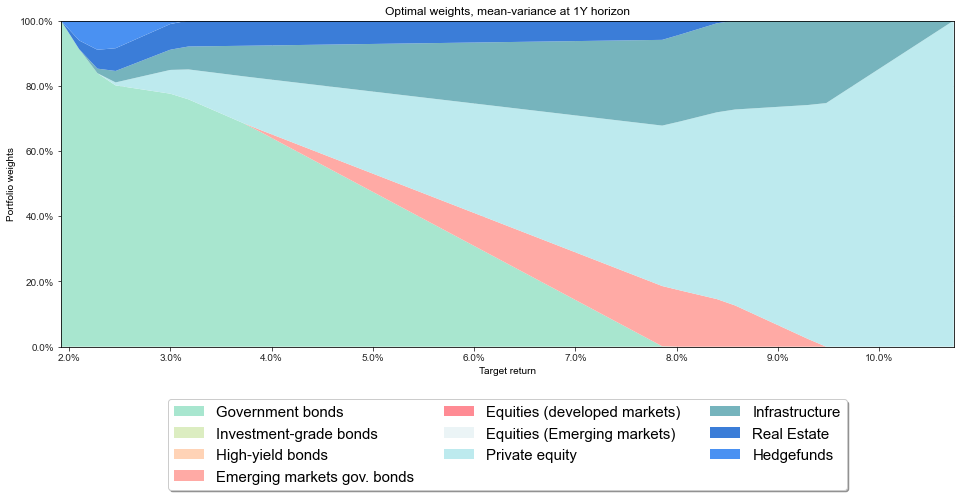

In [44]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(return_targets, eff_ports.T, labels=asset_names);
ax.set_xlabel("Target return")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, mean-variance at 1Y horizon")
ticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)
ax.xaxis.set_major_formatter(ticks)
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=3);

In [45]:
"""
Calculate minimum variance portfolio
"""

min_var_port = calculate_min_var_portfolio(sigma_l)

"""
Calculate tangency portfolio
"""

tan_port = calculate_tangency_portfolio(sigma_l, mu_l)

In [74]:
"""
Display portfolio weights
"""
df_port = pd.DataFrame({'min-var': min_var_port, 'tangency': tan_port}, index=asset_names)*100
df_port.round(3)

,min-var,tangency
Government bonds,80.93,76.68
Investment-grade bonds,0.00,0.00
High-yield bonds,0.00,0.00
Emerging markets gov. bonds,0.00,0.00
Equities (developed markets),0.00,0.00
Equities (Emerging markets),0.00,0.00
Private equity,0.00,8.58
Infrastructure,2.88,6.76
Real Estate,6.70,7.98
Hedgefunds,9.48,0.00


In [75]:
"""
Random portfolios
"""

random_ports = np.random.uniform(size=(1000, 10))
random_ports = (random_ports.T / random_ports.sum(axis=1)).T

In [76]:
"""
Calculate port. expected return along efficient frontier
"""

eff_port_exp_return = np.apply_along_axis(rm.calculate_portfolio_mean, 1, eff_ports, mu_l)
rand_port_exp_return = np.apply_along_axis(rm.calculate_portfolio_mean, 1, random_ports, mu_l)
min_var_port_exp_ret = rm.calculate_portfolio_mean(min_var_port, mu_l)
tan_port_exp_ret = rm.calculate_portfolio_mean(tan_port, mu_l)

"""
Calculate port. std
"""

eff_port_std = np.apply_along_axis(rm.calculate_portfolio_std, 1, eff_ports, sigma_l)
rand_port_std = np.apply_along_axis(rm.calculate_portfolio_std, 1, random_ports, sigma_l)
min_var_port_std = rm.calculate_portfolio_std(min_var_port, sigma_l)
tan_port_std = rm.calculate_portfolio_std(tan_port, sigma_l)

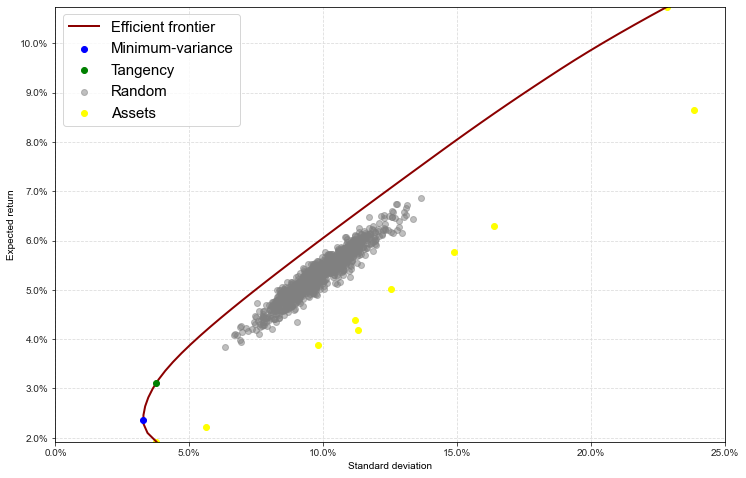

In [77]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(eff_port_std, eff_port_exp_return, label="Efficient frontier", color="darkred")
ax.scatter(min_var_port_std, min_var_port_exp_ret, label="Minimum-variance", color="blue", zorder=10)
ax.scatter(tan_port_std, tan_port_exp_ret, label="Tangency", color="green", zorder=10)
ax.scatter(rand_port_std, rand_port_exp_return, label="Random", color="gray", zorder=10, alpha=0.5)
ax.scatter(np.sqrt(np.diag(sigma_l)), mu_l, label="Assets", color="yellow")

ticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)
ax.xaxis.set_major_formatter(ticks)

ax.set(xlabel="Standard deviation", ylabel="Expected return")

ax.set_xlim([0.0, 0.25])

ax.legend();

## Relative risk contribution

We have the formula for the relative risk contribution with standard deviation as risk measure

$$
RRC_i =  w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} \frac{1}{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

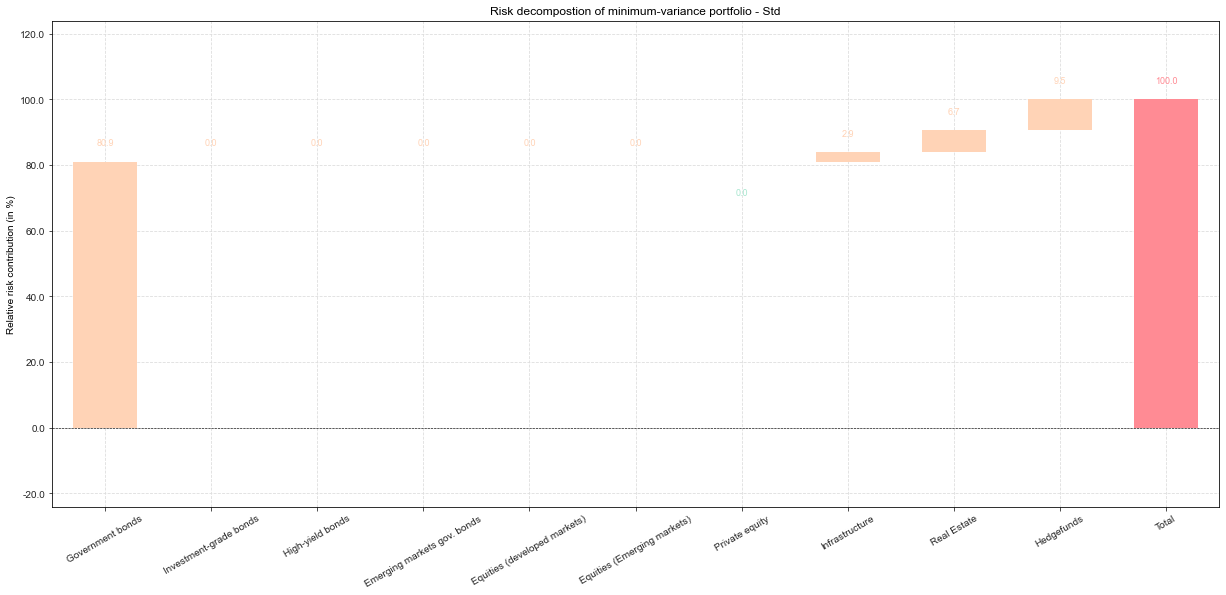

In [78]:
min_var_rrc = rb.calculate_risk_contributions_std(min_var_port, sigma_l, scale=True)

waterfall_chart(labels=asset_names, values=min_var_rrc*100)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Risk decompostion of minimum-variance portfolio - Std')
ax.set_ylabel('Relative risk contribution (in %)'); 

In [79]:
min_var_rrc.round(3)

array([0.809, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.029, 0.067,
       0.095])

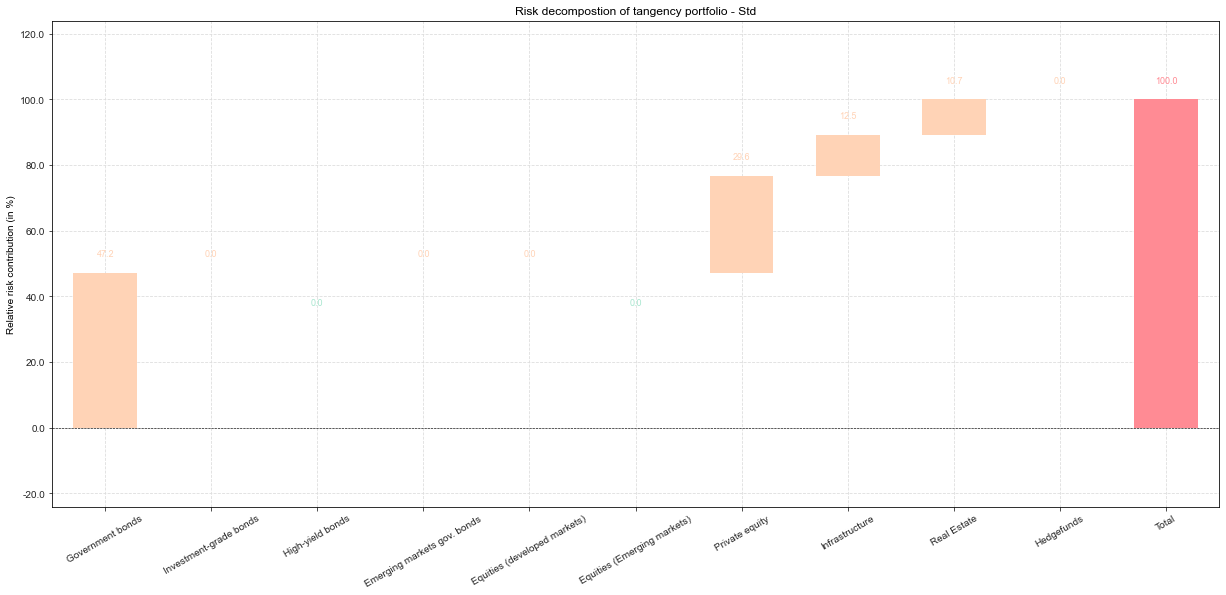

In [80]:
tan_rrc = rb.calculate_risk_contributions_std(tan_port, sigma_l, scale=True)

waterfall_chart(labels=asset_names, values=tan_rrc*100)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Risk decompostion of tangency portfolio - Std')
ax.set_ylabel('Relative risk contribution (in %)'); 

In [81]:
tan_rrc.round(3)

array([0.472, 0.   , 0.   , 0.   , 0.   , 0.   , 0.296, 0.125, 0.107,
       0.   ])

## Risk budget portfolio

In [156]:
"""
A simple implementation 
"""


def calculate_eq_risk_budget_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}
    
    # objective function 
    obj_func = lambda x: np.sum(np.square(rb.calculate_risk_contributions_std(x, cov_mat, scale=True) - 1.0 / n)) 
    
    # perform optimization
    res = optimize.minimize(obj_func,
                            init_weights,
                            constraints=[eq_constraint],
                            bounds=[(0, 1)]*n, 
                            options={'ftol':1e-16, 
                                      'eps':1e-12})
    
    return res.x



def calculate_eq_risk_budget_portfolio_cvxpy(cov_mat: np.ndarray): 
    
    sigma_sqrt = sqrtm(cov_mat)
    num_assets = cov_mat.shape[0]
    
    """
    Variables to optimize over
    """

    p = cp.Variable(nonneg=True)
    g = cp.Variable(nonneg=True)
    z = cp.Variable(num_assets)
    w = cp.Variable(num_assets)

    """
    Define objective
    """

    objective = cp.Minimize(p - g)

    """
    Constraints
    """
    constraints=[]

    # definition of zeta
    constraints.append(z==cov_mat @ w) 

    # sum to one
    constraints.append(cp.sum(w)==1.0) 

    # larger than zero constraints
    constraints += [p>=0,
                    g>=0,
                    z>=0,
                    w>=0]

    # risk bound
    constraints.append(cp.SOC(np.sqrt(num_assets) * p, sigma_sqrt.T @ w))

    # total risk
    for i in range(num_assets):
        constraints.append(cp.SOC(w[i] + z[i], cp.vstack([2 * g, w[i] - z[i]])))


    """
    Define problem
    """

    problem = cp.Problem(objective, constraints)

    """
    Solve problem 
    """
    problem.solve()

    """
    return portfolio weights
    """

    return w.value
    

In [157]:
rb_port = calculate_eq_risk_budget_portfolio(sigma_l, np.repeat(1.0 / 10.0, 10))

In [158]:
rb_port.sum()

1.0

In [172]:
rb_port = calculate_eq_risk_budget_portfolio_cvxpy(cov_mat)
rb_port

array([0.40503546, 0.14130728, 0.05119933, 0.06270667, 0.04348684,
       0.03171557, 0.03573372, 0.06814187, 0.08997817, 0.07069509])

In [173]:
"""
Comparing allocations
"""

df_port['ERC'] = rb_port*100
df_port.round(3)

,min-var,tangency,ERC
Government bonds,80.93,76.68,40.50
Investment-grade bonds,0.00,0.00,14.13
High-yield bonds,0.00,0.00,5.12
Emerging markets gov. bonds,0.00,0.00,6.27
Equities (developed markets),0.00,0.00,4.35
Equities (Emerging markets),0.00,0.00,3.17
Private equity,0.00,8.58,3.57
Infrastructure,2.88,6.76,6.81
Real Estate,6.70,7.98,9.00
Hedgefunds,9.48,0.00,7.07


In [174]:
"""
Calculate port. expected return along efficient frontier
"""

rb_port_exp_ret = rm.calculate_portfolio_mean(rb_port, mu_l)

"""
Calculate port. std
"""

rb_port_std = rm.calculate_portfolio_std(rb_port, sigma_l)

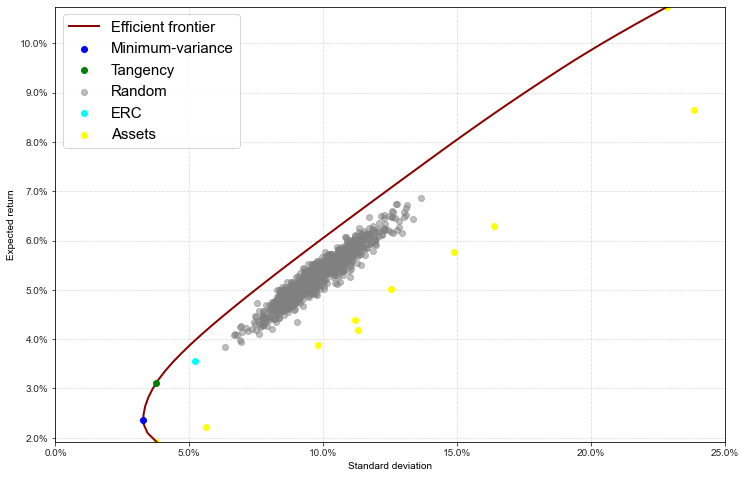

In [114]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(eff_port_std, eff_port_exp_return, label="Efficient frontier", color="darkred")
ax.scatter(min_var_port_std, min_var_port_exp_ret, label="Minimum-variance", color="blue", zorder=10)
ax.scatter(tan_port_std, tan_port_exp_ret, label="Tangency", color="green", zorder=10)
ax.scatter(rand_port_std, rand_port_exp_return, label="Random", color="gray", zorder=10, alpha=0.5)
ax.scatter(rb_port_std, rb_port_exp_ret, label="ERC", color="cyan", zorder=10)
ax.scatter(np.sqrt(np.diag(sigma_l)), mu_l, label="Assets", color="yellow")

ticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)
ax.xaxis.set_major_formatter(ticks)

ax.set(xlabel="Standard deviation", ylabel="Expected return")

ax.set_xlim([0.0, 0.25])

ax.legend();

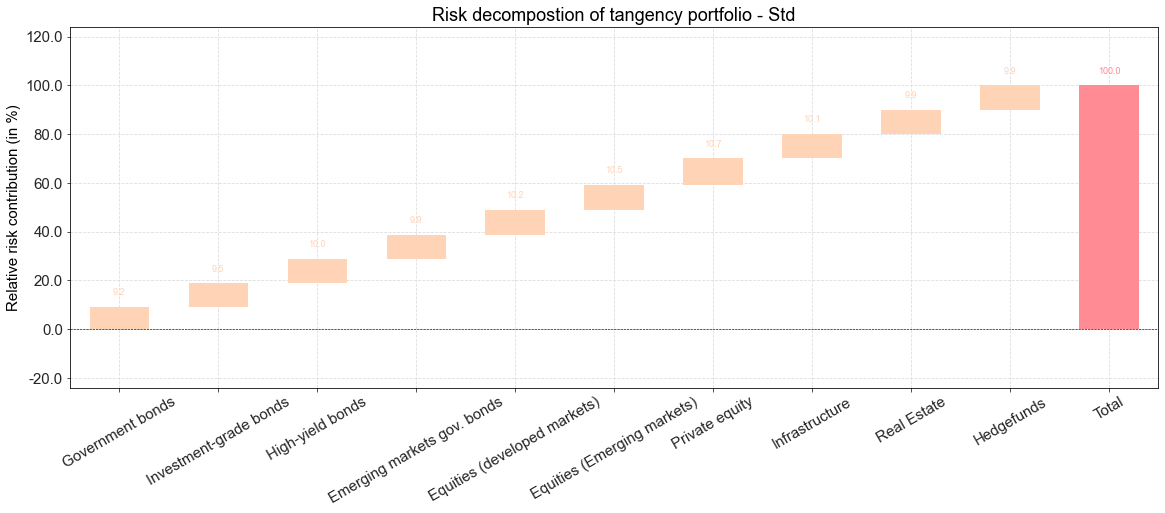

In [175]:
rb_rrc = rb.calculate_risk_contributions_std(rb_port, sigma_l, scale=True)

waterfall_chart(labels=asset_names, values=rb_rrc*100)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Risk decompostion of tangency portfolio - Std')
ax.set_ylabel('Relative risk contribution (in %)'); 

## Expected return, std. and Sharpe

In [176]:
pd.DataFrame(data=np.array([[min_var_port_exp_ret, min_var_port_std, min_var_port_exp_ret / min_var_port_std],
                            [tan_port_exp_ret, tan_port_std, tan_port_exp_ret / tan_port_std],
                            [rb_port_exp_ret, rb_port_std, rb_port_exp_ret / rb_port_std]]).T,
             index = ['E[R]', 'Std[R]', 'SR'], 
             columns=['Min-var', 'Tangency', 'ERC'])

,Min-var,Tangency,ERC
E[R],0.02,0.03,0.04
Std[R],0.03,0.04,0.05
SR,0.72,0.83,0.68


## Simulate distribution of realized mean, std. and Sharpe ratio over the next 50 years

In [117]:
"""
Simulate 50Y of returns 
"""

num_periods = 50

num_sim = int(1e4)

# asset prices
sim_prices = np.ones((num_sim, 1 + num_periods, 10))
sim_prices[:, 1:, :] = np.exp(np.cumsum(np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_periods)), axis=1))

# asset returns 
sim_ret = sim_prices[:, 1:, :] / sim_prices[:, :-1, :] - 1.0 

tan_port_ret = sim_ret @ tan_port
min_var_port_ret = sim_ret @ min_var_port
rb_port_ret = sim_ret @ rb_port

In [118]:
sim_exp_tan = np.mean(tan_port_ret, axis=1)
sim_exp_min_var = np.mean(min_var_port_ret, axis=1)
sim_exp_rb = np.mean(rb_port_ret, axis=1)

sim_std_tan = np.std(tan_port_ret, axis=1)
sim_std_min_var = np.std(min_var_port_ret, axis=1)
sim_std_rb = np.std(rb_port_ret, axis=1)


sim_sr_tan = sim_exp_tan / sim_std_tan
sim_sr_min_var = sim_exp_min_var / sim_std_min_var
sim_sr_rb = sim_exp_rb / sim_std_rb

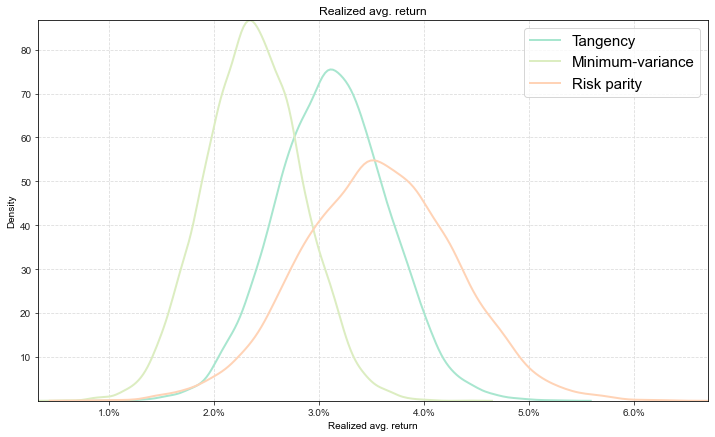

In [119]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.kdeplot(sim_exp_tan, label="Tangency")
sns.kdeplot(sim_exp_min_var, label="Minimum-variance")
sns.kdeplot(sim_exp_rb, label="Risk parity")

ticks = mtick.PercentFormatter(1)
ax.xaxis.set_major_formatter(ticks)
ax.set_xlabel('Realized avg. return')
ax.set_title('Realized avg. return')

ax.legend();

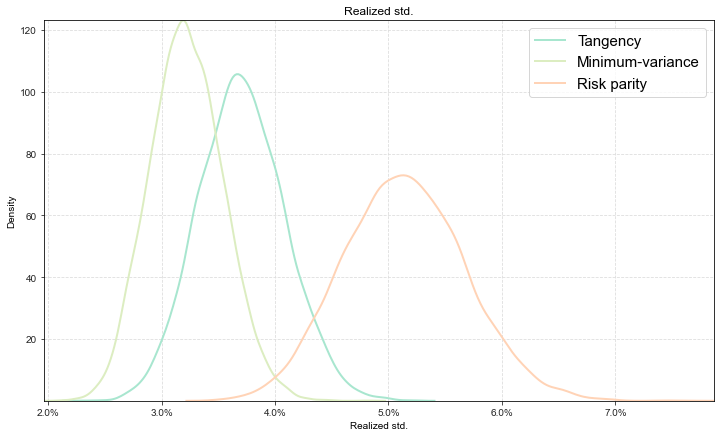

In [120]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.kdeplot(sim_std_tan, label="Tangency")
sns.kdeplot(sim_std_min_var, label="Minimum-variance")
sns.kdeplot(sim_std_rb, label="Risk parity")

ticks = mtick.PercentFormatter(1)
ax.xaxis.set_major_formatter(ticks)
ax.set_xlabel('Realized std.')
ax.set_title('Realized std.')

ax.legend();

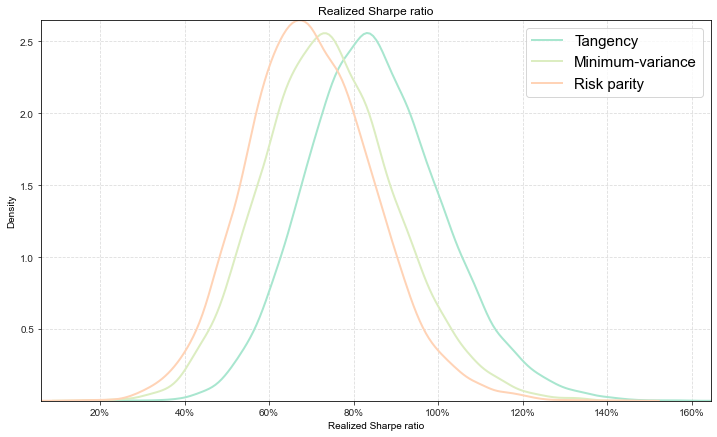

In [121]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.kdeplot(sim_sr_tan, label="Tangency")
sns.kdeplot(sim_sr_min_var, label="Minimum-variance")
sns.kdeplot(sim_sr_rb, label="Risk parity")

ticks = mtick.PercentFormatter(1)
ax.xaxis.set_major_formatter(ticks)
ax.set_xlabel('Realized Sharpe ratio')
ax.set_title('Realized Sharpe ratio')

ax.legend();

## Realized optimal portfolios

In [163]:
"""
For each simulation, calculate the optimal portfolios and store results
"""

sim_min_var_ports = []
sim_tan_ports = []
sim_rb_ports = []

for i in range(num_sim): 
    
    mu_temp = np.mean(sim_ret[i, :, :], axis=0)
    sigma_temp = np.cov(sim_ret[i, :, :].T)
    
    temp_min_var_port = calculate_min_var_portfolio(cov_mat=sigma_temp)
    temp_tan_port = calculate_tangency_portfolio(cov_mat=sigma_temp, mu=mu_temp)
    temp_rb_port = calculate_eq_risk_budget_portfolio_cvxpy(cov_mat=sigma_temp)
    #calculate_eq_risk_budget_portfolio(cov_mat=sigma_temp)
    
    sim_min_var_ports.append(temp_min_var_port)
    sim_tan_ports.append(temp_tan_port)
    sim_rb_ports.append(temp_rb_port)
    

sim_min_var_ports = np.array(sim_min_var_ports)
sim_tan_ports = np.array(sim_tan_ports)
sim_rb_ports = np.array(sim_rb_ports)

C:\environments\python_for_fin_econ\lib\site-packages\cvxpy\problems\problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [164]:
sim_rb_ports.shape

(10000, 10)

In [177]:
"""
Calculate the 1Y expectation, std and SR for each portfolio. 
"""


sim_min_var_ports_mean = np.apply_along_axis(rm.calculate_portfolio_mean, 1, sim_min_var_ports, mu_l)
sim_min_var_ports_std = np.apply_along_axis(rm.calculate_portfolio_std, 1, sim_min_var_ports, sigma_l)
sim_min_var_ports_sr = sim_min_var_ports_mean / sim_min_var_ports_std


sim_tan_ports_mean = np.apply_along_axis(rm.calculate_portfolio_mean, 1, sim_tan_ports, mu_l)
sim_tan_ports_std = np.apply_along_axis(rm.calculate_portfolio_std, 1, sim_tan_ports, sigma_l)
sim_tan_ports_sr = sim_tan_ports_mean / sim_tan_ports_std


sim_rb_ports_mean = np.apply_along_axis(rm.calculate_portfolio_mean, 1, sim_rb_ports, mu_l)
sim_rb_ports_std = np.apply_along_axis(rm.calculate_portfolio_std, 1, sim_rb_ports, sigma_l)
sim_rb_ports_sr = sim_rb_ports_mean / sim_rb_ports_std

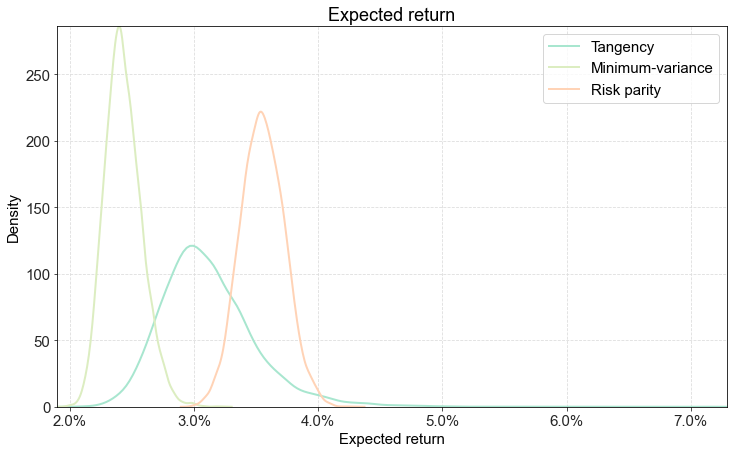

In [178]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.kdeplot(sim_tan_ports_mean, label="Tangency")
sns.kdeplot(sim_min_var_ports_mean, label="Minimum-variance")
sns.kdeplot(sim_rb_ports_mean, label="Risk parity")


ticks = mtick.PercentFormatter(1)
ax.xaxis.set_major_formatter(ticks)
ax.set_xlabel('Expected return')
ax.set_title('Expected return')

ax.legend();

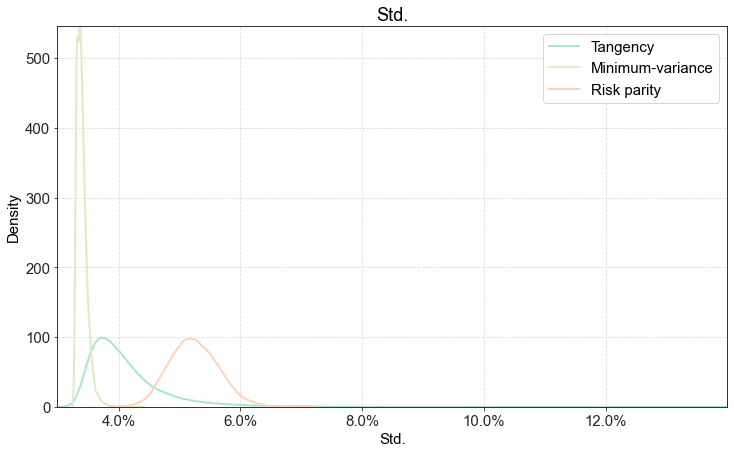

In [179]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.kdeplot(sim_tan_ports_std, label="Tangency")
sns.kdeplot(sim_min_var_ports_std, label="Minimum-variance")
sns.kdeplot(sim_rb_ports_std, label="Risk parity")


ticks = mtick.PercentFormatter(1)
ax.xaxis.set_major_formatter(ticks)
ax.set_xlabel('Std.')
ax.set_title('Std.')

ax.legend();

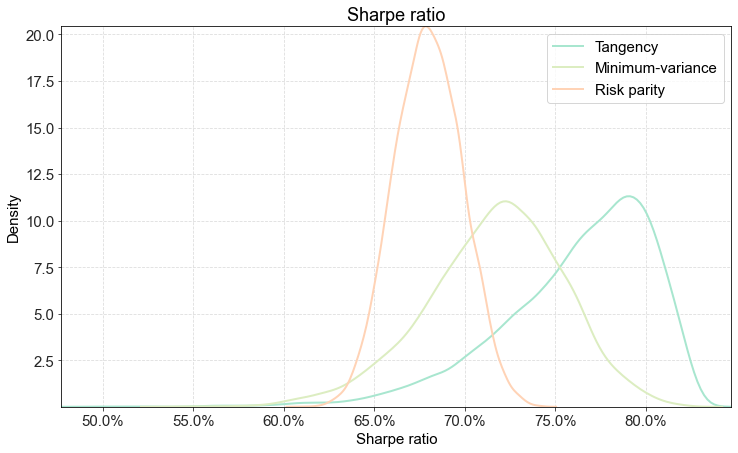

In [180]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.kdeplot(sim_tan_ports_sr, label="Tangency")
sns.kdeplot(sim_min_var_ports_sr, label="Minimum-variance")
sns.kdeplot(sim_rb_ports_sr, label="Risk parity")


ticks = mtick.PercentFormatter(1)
ax.xaxis.set_major_formatter(ticks)
ax.set_xlabel('Sharpe ratio')
ax.set_title('Sharpe ratio')

ax.legend();

## Distribution of portfolio weights

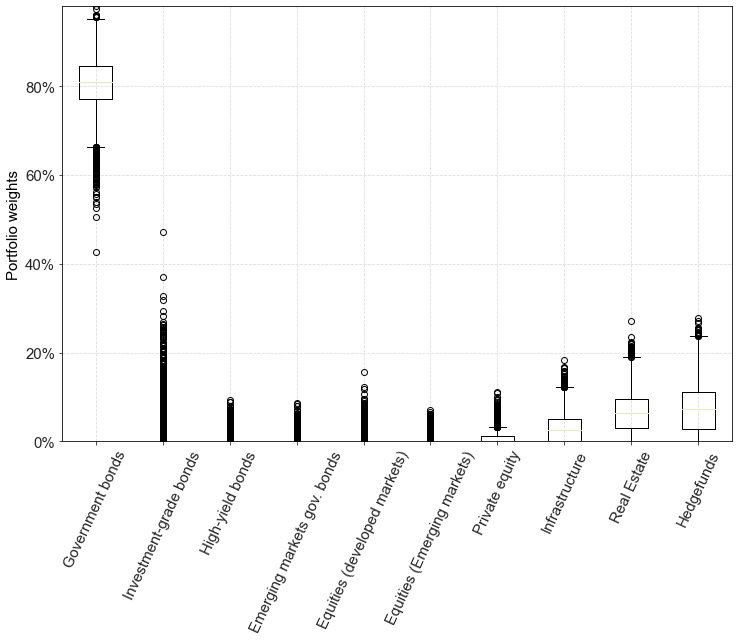

In [181]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(sim_min_var_ports)
ax.set_xticklabels(labels=asset_names, rotation=65)

ticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)
ax.set_ylabel('Portfolio weights');

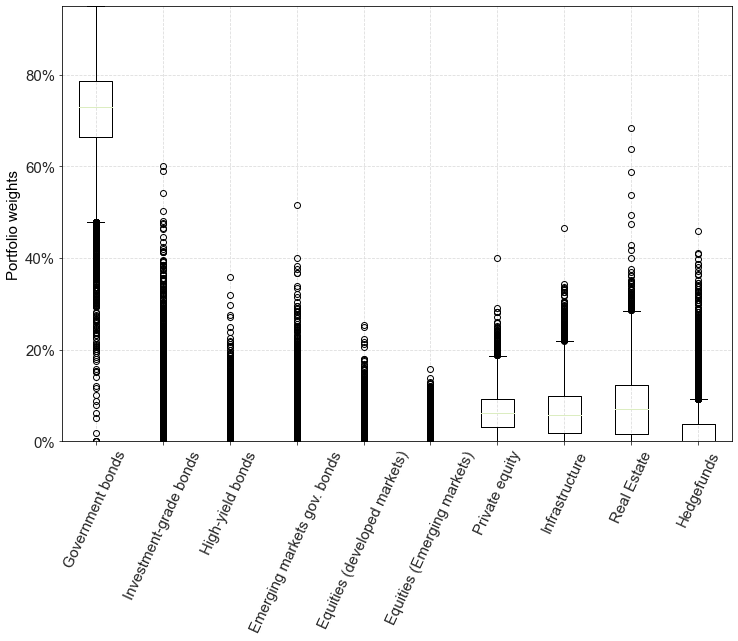

In [182]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(sim_tan_ports)
ax.set_xticklabels(labels=asset_names, rotation=65)


ticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)
ax.set_ylabel('Portfolio weights');

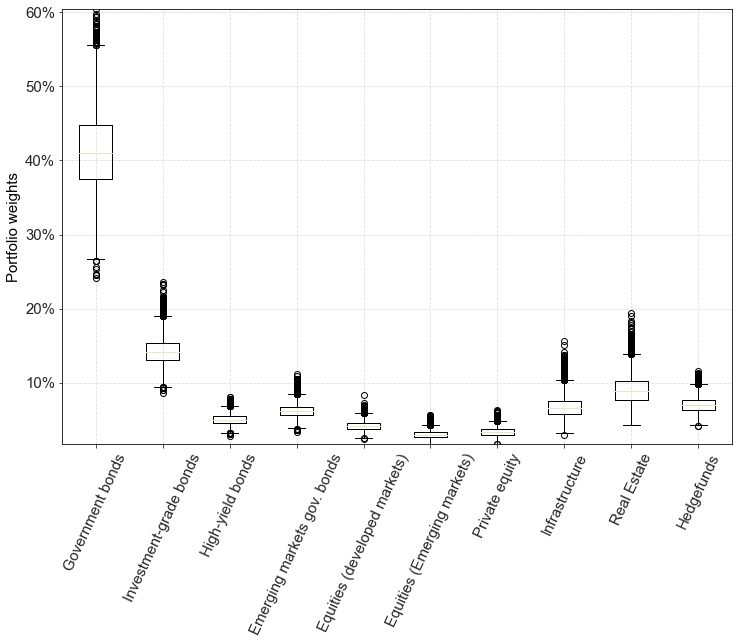

In [183]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(sim_rb_ports)
ax.set_xticklabels(labels=asset_names, rotation=65)


ticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)
ax.set_ylabel('Portfolio weights');